### Missing value imputation using Hotdeck imputation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import seaborn as sns
from pandas_profiling import ProfileReport
import warnings
warnings.filterwarnings("ignore")
import missingno as msno
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from scipy.stats import shapiro
# imputer
from sklearn.impute import SimpleImputer, KNNImputer




url1 ='https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data'
names = ["feature" + str(x) for x in range(1, 591)]
df1 = pd.read_csv(url1,sep=" ", names=names, na_values = "NaN",header=None)
df1.head()

url2 ='https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data'
df2 = pd.read_csv(url2,sep=" ",names = ["Result","Date"])

#df2.columns =['Pass/Fail','Date']
df2.head()




#Convertion of Date into Datetime from Object(String) data types
df2['Date'] = pd.to_datetime(df2['Date'])
df2.dtypes



#Joinig TWO df1 and df2 Dataframe naming SECOM
Secom = pd.concat([df1,df2],axis = 1)
print(Secom)

Secom = Secom.drop(['Date'],axis=1)
                   
# establish target and features of the manufacturing data
# set the target to the encoded manufacturing outcome column
y = Secom[['Result']]
# set the features as the rest of the dataset after dropping the features that are no
x = Secom.drop(['Result'], axis=1)

# getting the shapes of new data sets x and y
print("shape of x:", x.shape)
print("shape of y:", y.shape)

#Splitting data


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 1,stratify = y)



# getting the counts
print("shape of x_train: ", x_train.shape)
print("shape of x_test: ", x_test.shape)
print("shape of y_train: ", y_train.shape)
print("shape of y_test: ", y_test.shape)




#Removing features having Missing ratio more than 50%


def percentna(dataframe, threshold):
    columns = dataframe.columns[(dataframe.isnull().sum()/len(dataframe))>threshold]
    return columns.tolist()

 

na_columns = percentna(x_train, 0.5)
len(na_columns)
x_train_dn = x_train.drop(na_columns, axis=1)
x_train_dn.shape





#Low Variance Filter
from sklearn.feature_selection import VarianceThreshold
var_thres=VarianceThreshold(threshold=0)
var_thres.fit(x_train_dn)

 

constant_columns = [column for column in x_train_dn.columns
                    if column not in x_train_dn.columns[var_thres.get_support()]]


print(len(constant_columns))

x_train_lv = x_train_dn.drop(constant_columns,axis=1)

      feature1  feature2   feature3   feature4  feature5  feature6  feature7  \
0      3030.93   2564.00  2187.7333  1411.1265    1.3602     100.0   97.6133   
1      3095.78   2465.14  2230.4222  1463.6606    0.8294     100.0  102.3433   
2      2932.61   2559.94  2186.4111  1698.0172    1.5102     100.0   95.4878   
3      2988.72   2479.90  2199.0333   909.7926    1.3204     100.0  104.2367   
4      3032.24   2502.87  2233.3667  1326.5200    1.5334     100.0  100.3967   
...        ...       ...        ...        ...       ...       ...       ...   
1562   2899.41   2464.36  2179.7333  3085.3781    1.4843     100.0   82.2467   
1563   3052.31   2522.55  2198.5667  1124.6595    0.8763     100.0   98.4689   
1564   2978.81   2379.78  2206.3000  1110.4967    0.8236     100.0   99.4122   
1565   2894.92   2532.01  2177.0333  1183.7287    1.5726     100.0   98.7978   
1566   2944.92   2450.76  2195.4444  2914.1792    1.5978     100.0   85.1011   

      feature8  feature9  feature10  ..

In [2]:
def outliers(feat):
 upper_limit = feat.mean() + 3*feat.std()
 lower_limit = feat.mean() - 3*feat.std()

 feat = np.where(
    feat >upper_limit,
    upper_limit,
    np.where(
       feat <lower_limit,
        lower_limit,
        feat ))
 return feat

x_train_outliers_imputation =x_train_lv.copy()
for column in x_train_outliers_imputation:
  x_train_outliers_imputation[column] = outliers(x_train_outliers_imputation[column])

### Missing value imputation

In [8]:
#Hot deck (LOCF - last observation carried forward )
numColumns = x_train_outliers_imputation.select_dtypes(include=np.number).columns.tolist();
x_train_Hot_deck1 = x_train_outliers_imputation.copy()
x_test_Hot_deck1 = x_test.copy()
x_train_Hot_deck1[numColumns] = x_train_Hot_deck1[numColumns].fillna(method ='ffill')
x_test_Hot_deck1[numColumns] = x_test_Hot_deck1[numColumns].fillna(method ='ffill')

#num_cols_with_na = num_cols[x_train_Hot_deck1[num_cols].isnull().mean() > 0]
#print(f"*** numerical columns that have NaN's ({len(num_cols_with_na)}): \n{num_cols_with_na}\n\n")


x_train_Hot_deck1.isnull().mean().sort_values(ascending =False)
x_test_Hot_deck1.isnull().mean().sort_values(ascending =False)

feature158    0.910828
feature294    0.910828
feature159    0.910828
feature293    0.910828
feature359    0.842887
                ...   
feature196    0.000000
feature189    0.000000
feature188    0.000000
feature186    0.000000
feature590    0.000000
Length: 590, dtype: float64

## PCA

In [71]:
x_train_Hot_deck1 = x_train_Hot_deck1.replace(np.NaN, 0)
x_train_Hot_deck1.isnull().any().any()
x_test_Hot_deck1 = x_test_Hot_deck1.replace(np.NaN, 0)
x_test_Hot_deck1.isnull().any().any()

from sklearn.preprocessing import MinMaxScaler
col=list(x_train_Hot_deck1.columns)
col1=list(x_test_Hot_deck1.columns)
scaler = MinMaxScaler()
scaled_feature = scaler.fit_transform(x_train_Hot_deck1)
scaled_feature = pd.DataFrame(scaled_feature,columns=col)




In [68]:
from sklearn.decomposition import PCA
import numpy as np
# Creating a covariance matrix

cov_matrix = np.cov(scaled_feature.T)
print('Covariance Matrix \n', cov_matrix)
      
#perform an eigendecomposition on the covariance matrix:

eig_vals, eig_vecs = np.linalg.eig(cov_matrix)  

Covariance Matrix 
 [[ 0.02666171 -0.00391903 -0.0004119  ... -0.00068501 -0.00082912
  -0.00049517]
 [-0.00391903  0.02587981  0.00141343 ...  0.00059784  0.00021879
   0.00104984]
 [-0.0004119   0.00141343  0.02533753 ... -0.00145765 -0.0012851
  -0.00132929]
 ...
 [-0.00068501  0.00059784 -0.00145765 ...  0.04180772  0.04087806
   0.01890912]
 [-0.00082912  0.00021879 -0.0012851  ...  0.04087806  0.04238487
   0.01892334]
 [-0.00049517  0.00104984 -0.00132929 ...  0.01890912  0.01892334
   0.04449568]]


In [47]:
tot = sum(eig_vals)
var_exp = [( i /tot ) * 100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print("Cumulative Variance Explained", cum_var_exp)

Cumulative Variance Explained [  4.5268127    7.63760896  10.56118     13.09252302  15.30016586
  17.37631117  19.28921383  21.10282039  22.83767038  24.5324992
  26.19364848  27.80928227  29.32263953  30.74480414  32.09937645
  33.38856484  34.66033667  35.92160672  37.13115282  38.3003586
  39.40123953  40.4835075   41.53579454  42.57420595  43.59784977
  44.59633875  45.55896288  46.50985708  47.4467211   48.36724143
  49.2663899   50.14785718  51.01505761  51.85691767  52.68501081
  53.49694017  54.30041836  55.08828727  55.86386623  56.63480309
  57.38619957  58.13453734  58.86401744  59.58201158  60.29473055
  60.99133211  61.67163053  62.34191461  62.99920405  63.64515182
  64.28509096  64.91288801  65.53352591  66.14307639  66.75089966
  67.34073888  67.923248    68.49288607  69.04192783  69.58120008
  70.11260225  70.62402341  71.12653354  71.62383945  72.1184046
  72.60123486  73.07848065  73.54752335  74.00612014  74.45794761
  74.9025317   75.33416767  75.76207926  76.17980

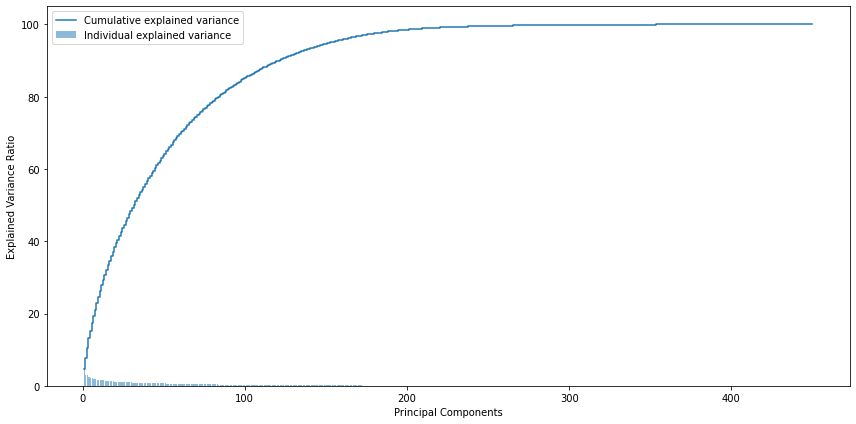

In [48]:
plt.figure(figsize=(12 ,6))
plt.bar(range(1, eig_vals.size + 1), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(1, eig_vals.size + 1), cum_var_exp, where='mid', label = 'Cumulative explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()  

In [49]:
pca = PCA(n_components=scaled_feature.shape[1],random_state=1).fit(scaled_feature.values)
a = np.cumsum(pca.explained_variance_ratio_)

In [50]:
i = 0
while a[i] < 0.9:
    i = i+1
f'Number of dimensions needed to capture 90%% of variance:{i}'

'Number of dimensions needed to capture 90%% of variance:120'

In [51]:
# PCA with reduced number of components

pca = PCA(n_components=i,random_state=1)
pca.fit(scaled_feature)
#print(pca.components_)

pca_df= pd.DataFrame(pca.fit_transform(scaled_feature))
print(pca_df)

           0         1         2         3         4         5         6    \
0    -0.476052 -0.131352  0.595197  0.082932 -0.353662 -0.170130  1.709199   
1    -0.907851 -0.414648 -0.155381 -0.505280  1.442272  0.495316  0.840219   
2     1.168219 -1.023466  0.292684  0.279238 -0.434417 -0.235960 -0.448179   
3     0.657013 -0.281172 -0.133687 -0.331859 -0.313169 -0.533784  0.736587   
4     1.340654 -0.890764  0.432481 -0.300933  0.246227 -0.381536 -0.099981   
...        ...       ...       ...       ...       ...       ...       ...   
1091  0.598920 -0.704990  0.678523  0.293653 -0.283096 -0.031549 -0.351352   
1092 -1.098254  0.221194 -0.700623 -0.054759  0.599481  0.250703 -0.013581   
1093 -0.321829 -0.253608 -0.601915 -0.763140  0.848750  0.350051  0.082802   
1094 -0.802193  0.149002  0.260894  0.049569  0.098310  0.408709 -0.379729   
1095 -0.062557  0.202749 -0.375115 -1.241672 -0.153114  0.071980  1.131672   

           7         8         9    ...       110       111    

In [52]:
pca_df.shape

(1096, 120)

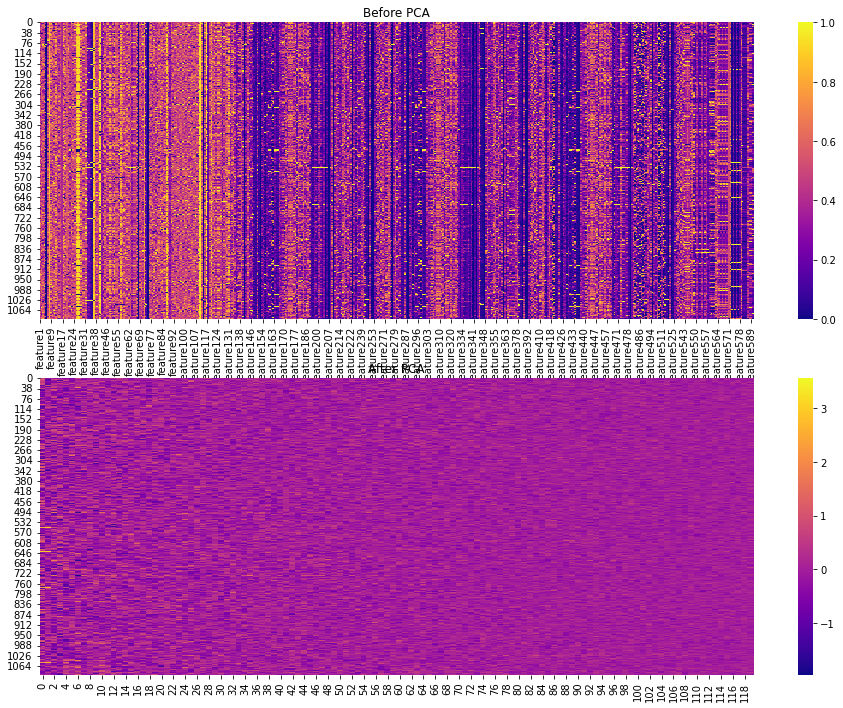

In [53]:
#heatmap before and after PCA
# after PCA shows that the components are in the acceptable range of colinearity: means that the components are independent and  suitable for model making.
f, (ax_heatmap, ax_heatmap2) = plt.subplots(2,figsize=(16,12))
ax_heatmap.set_title('Before PCA')
ax_heatmap2.set_title('After PCA')

sns.heatmap(scaled_feature,ax=ax_heatmap,cmap='plasma');
sns.heatmap(pca_df,ax=ax_heatmap2,cmap='plasma');

In [54]:
from sklearn.decomposition import PCA
# create a PCA object
pca = PCA(n_components = i)# extracted features we want to end up within our new dataset(2).
# Apply the above object to our training dataset using the fit method.
X_train = pca.fit_transform(x_train_Hot_deck1)
# Apply the PCA object to the test set only to transform this set
X_test = pca.fit_transform(x_test_Hot_deck1)

In [55]:
# Importing the LogisticRegression class from the linear_model module in sklearn
from sklearn.linear_model import LogisticRegression
# create object of the above classifier
clfy = LogisticRegression(random_state = 0) # pass seed to ensure results are reproducible
clfy.fit(X_train, y_train) # calls fit method from the classifier object to fit the data to our model

LogisticRegression(random_state=0)

In [56]:
# Importing the confusion_matrix and accuracy_score class from the metrics module in sklearn
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = clfy.predict(X_test) # calls a predict method from the classfier object to target variable of the X_test
# creating a confussion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
# model score
pcr1=accuracy_score(y_test, y_pred) 
print("Precision Recall Score:" ,pcr1)

[[219 221]
 [ 16  15]]
Precision Recall Score: 0.4968152866242038


## Evaluation Check

In [92]:

import warnings
warnings.filterwarnings("ignore")
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
#from sklearn.metrics import scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV

classifiers = [['Naive Bayes :', GaussianNB()],
               ['KNeighbours :', KNeighborsClassifier()],
               ['SVM :', SVC()],
               ['LogisticRegression :', LogisticRegression()],
               ['DecisionTree :',DecisionTreeClassifier()],
               ['RandomForest :',RandomForestClassifier()]]

for name,classifier in classifiers:
    clf=classifier.fit(X_train,y_train)
    y_pred=classifier.predict(X_test )
    print(f'\n {name} \n')
    print(f'Training Score for {name}  {clf.score(X_train,y_train) * 100:.2f}' )
    print(f'Testing Score for {name} {clf.score(X_test,y_test) * 100:.2f}' )
    print(f'Classification report  \n {classification_report(y_test,y_pred)}' )
    print(f'Confusion matrix  \n {confusion_matrix(y_test,y_pred)}' )
    print(f'ROC AUC  : {roc_auc_score(y_test,y_pred)}' )


 Naive Bayes : 

Training Score for Naive Bayes :  89.23
Testing Score for Naive Bayes : 88.96
Classification report  
               precision    recall  f1-score   support

          -1       0.93      0.95      0.94       440
           1       0.00      0.00      0.00        31

    accuracy                           0.89       471
   macro avg       0.47      0.48      0.47       471
weighted avg       0.87      0.89      0.88       471

Confusion matrix  
 [[419  21]
 [ 31   0]]
ROC AUC  : 0.47613636363636364

 KNeighbours : 

Training Score for KNeighbours :  93.43
Testing Score for KNeighbours : 93.21
Classification report  
               precision    recall  f1-score   support

          -1       0.93      1.00      0.96       440
           1       0.00      0.00      0.00        31

    accuracy                           0.93       471
   macro avg       0.47      0.50      0.48       471
weighted avg       0.87      0.93      0.90       471

Confusion matrix  
 [[439   1]